In [373]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [418]:
def resize_image(img, new_size=(256, 256)):
    return cv.resize(img, new_size)

def insertGambar(folder):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    data_distribution = {}
    for label in (os.listdir(folder)):
        images = os.listdir(folder+label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        count = 0
        for filename in tqdm(os.listdir(folder+label)):
            if count == 100:
                break
            else :
                count += 1
            img = cv.imread(os.path.join(folder+label,filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (256, 256))
                filenames.append(filename)
                path.append(label)
                data.append(img)
    return data, filenames, datalabel, path , data_distribution

In [376]:
images, filenames, labels, path, distribusi = insertGambar("Dataset2/")

print("Jumlah gambar:", len(images))
print("Jumlah label unik:", len(labels))
print("Jumlah nama file:", len(filenames))
print("Distribusi data:", distribusi)


Acne Vulgaris


100%|██████████| 100/100 [00:03<00:00, 29.48it/s]


Rosacea


100%|██████████| 100/100 [00:03<00:00, 30.13it/s]


Jumlah gambar: 200
Jumlah label unik: 2
Jumlah nama file: 200
Distribusi data: {'Acne Vulgaris': 100, 'Rosacea': 100}


In [377]:
def display_sample(images):
  plt.figure(figsize=(20,10))
  for i in range(7):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
  plt.show()    

In [378]:
def equalize_histogram(img):
    return cv.equalizeHist(img)

In [379]:
def gray_scaling(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return gray

In [380]:
def median_filtering(img):
    pad = 1
    padded_img = np.pad(img, pad, mode='edge')
    result = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = padded_img[i:i+3, j:j+3].flatten()
            result[i, j] = np.median(window)
    return result

In [381]:
def sobel(image):
    sobel_x = np.array([[1, 0, -1], 
                        [2, 0, -2], 
                        [1, 0, -1]])
    sobel_y = np.array([[1, 2, 1], 
                        [0, 0, 0], 
                        [-1, -2, -1]])
    
    padded_img = np.pad(image, pad_width=1, mode='constant', constant_values=0)
    sobel_result = np.zeros_like(image, dtype=np.uint8)
    
    for i in range(1, padded_img.shape[0] - 1):
        for j in range(1, padded_img.shape[1] - 1):
            region = padded_img[i-1:i+2, j-1:j+2]

            gx = np.sum(region * sobel_x)
            gy = np.sum(region * sobel_y)

            sobel_result[i-1, j-1] = np.sqrt(gx**2 + gy**2)
    sobel_result = (sobel_result / np.max(sobel_result) * 255).astype(np.uint8)
    
    return sobel_result

In [382]:
def erosi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.min(region[kernel == 1])
    return result

def dilasi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.max(region[kernel == 1])
    return result

def opening(citra):
    kernel = np.ones((3, 3), dtype=np.uint8)
    citra_erosi = erosi(citra, kernel)
    citra_opening = dilasi(citra_erosi, kernel)
    return citra_opening


In [383]:
def normalize(image, skala_min=0, skala_max=255):
    image = image.astype(np.float32)
    min_val, max_val = np.min(image), np.max(image)

    if max_val == min_val:
        return np.full(image.shape, skala_min, dtype=np.uint8)  

    return ((image - min_val) * (skala_max - skala_min) / (max_val - min_val) + skala_min).astype(np.uint8)

In [384]:
import numpy as np

def manual_clahe(gray_img: np.ndarray, clip_limit: float = 2.0, tile_grid_size: tuple = (8, 8)) -> np.ndarray:
    h, w = gray_img.shape
    n_tiles_x, n_tiles_y = tile_grid_size
    tile_h = h // n_tiles_y
    tile_w = w // n_tiles_x
    bins = 256
    
    # Hitung clip limit aktual dalam jumlah pixel
    tile_size = tile_h * tile_w
    clip_limit_pixel = int((clip_limit * tile_size) / bins)
    
    # Buat hasil yang akan diisi
    result = np.zeros_like(gray_img, dtype=np.uint8)
    
    # Simpan semua mapping untuk setiap tile
    maps = np.zeros((n_tiles_y, n_tiles_x, bins), dtype=np.uint8)

    # Hitung histogram & mapping untuk tiap tile
    for i in range(n_tiles_y):
        for j in range(n_tiles_x):
            y0, y1 = i * tile_h, (i + 1) * tile_h
            x0, x1 = j * tile_w, (j + 1) * tile_w
            tile = gray_img[y0:y1, x0:x1]
            
            hist, _ = np.histogram(tile, bins=bins, range=(0, 256))
            
            # Clipping
            excess = np.maximum(hist - clip_limit_pixel, 0)
            clipped_hist = hist.copy()
            clipped_hist[clipped_hist > clip_limit_pixel] = clip_limit_pixel
            redistribute = np.sum(excess) // bins
            clipped_hist += redistribute
            
            # Hitung CDF
            cdf = np.cumsum(clipped_hist)
            cdf_min = cdf.min()
            cdf_range = cdf.max() - cdf_min
            if cdf_range == 0:
                cdf_range = 1
            mapping = ((cdf - cdf_min) * 255 / cdf_range).astype(np.uint8)
            maps[i, j] = mapping
    
    # Interpolasi antar tile
    for i in range(h):
        for j in range(w):
            # Posisi relatif di grid tile
            y_frac = (i + 0.5) / tile_h - 0.5
            x_frac = (j + 0.5) / tile_w - 0.5

            y = int(np.floor(y_frac))
            x = int(np.floor(x_frac))

            y = max(0, min(y, n_tiles_y - 2))
            x = max(0, min(x, n_tiles_x - 2))

            dy = y_frac - y
            dx = x_frac - x

            val = gray_img[i, j]

            # Ambil 4 tetangga mapping
            m00 = maps[y, x, val]
            m01 = maps[y, x + 1, val]
            m10 = maps[y + 1, x, val]
            m11 = maps[y + 1, x + 1, val]

            # Bilinear interpolation
            top = (1 - dx) * m00 + dx * m01
            bottom = (1 - dx) * m10 + dx * m11
            interpolated_val = (1 - dy) * top + dy * bottom
            result[i, j] = np.clip(int(round(interpolated_val)), 0, 255)


    return result


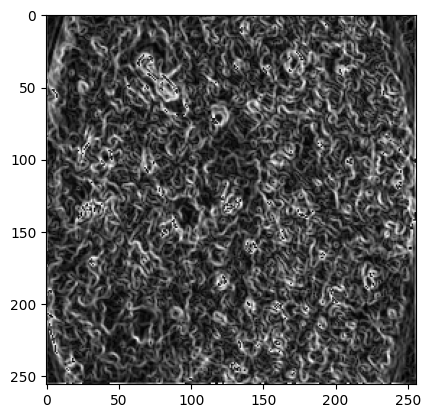

In [385]:
resize_img = resize_image(images[1])  
gray_img = gray_scaling(resize_img)  

citra_clahe = manual_clahe(gray_img, 5, (4,4))

medianData = median_filtering(citra_clahe)  
citra_sobel = sobel(medianData)  

normalizeData = normalize(citra_sobel)  

plt.imshow(normalizeData, cmap="gray")


In [386]:
dataPreprocessed = []
for i in range(len(images)):  
    resize_img = resize_image(images[i])  
    gray_img = gray_scaling(resize_img)  
    
    citra_clahe = manual_clahe(gray_img, 5, (4, 4))
    
    medianData = median_filtering(citra_clahe)  
    citra_sobel = sobel(medianData)  
    
    normalizeData = normalize(citra_sobel)  

    dataPreprocessed.append(normalizeData)

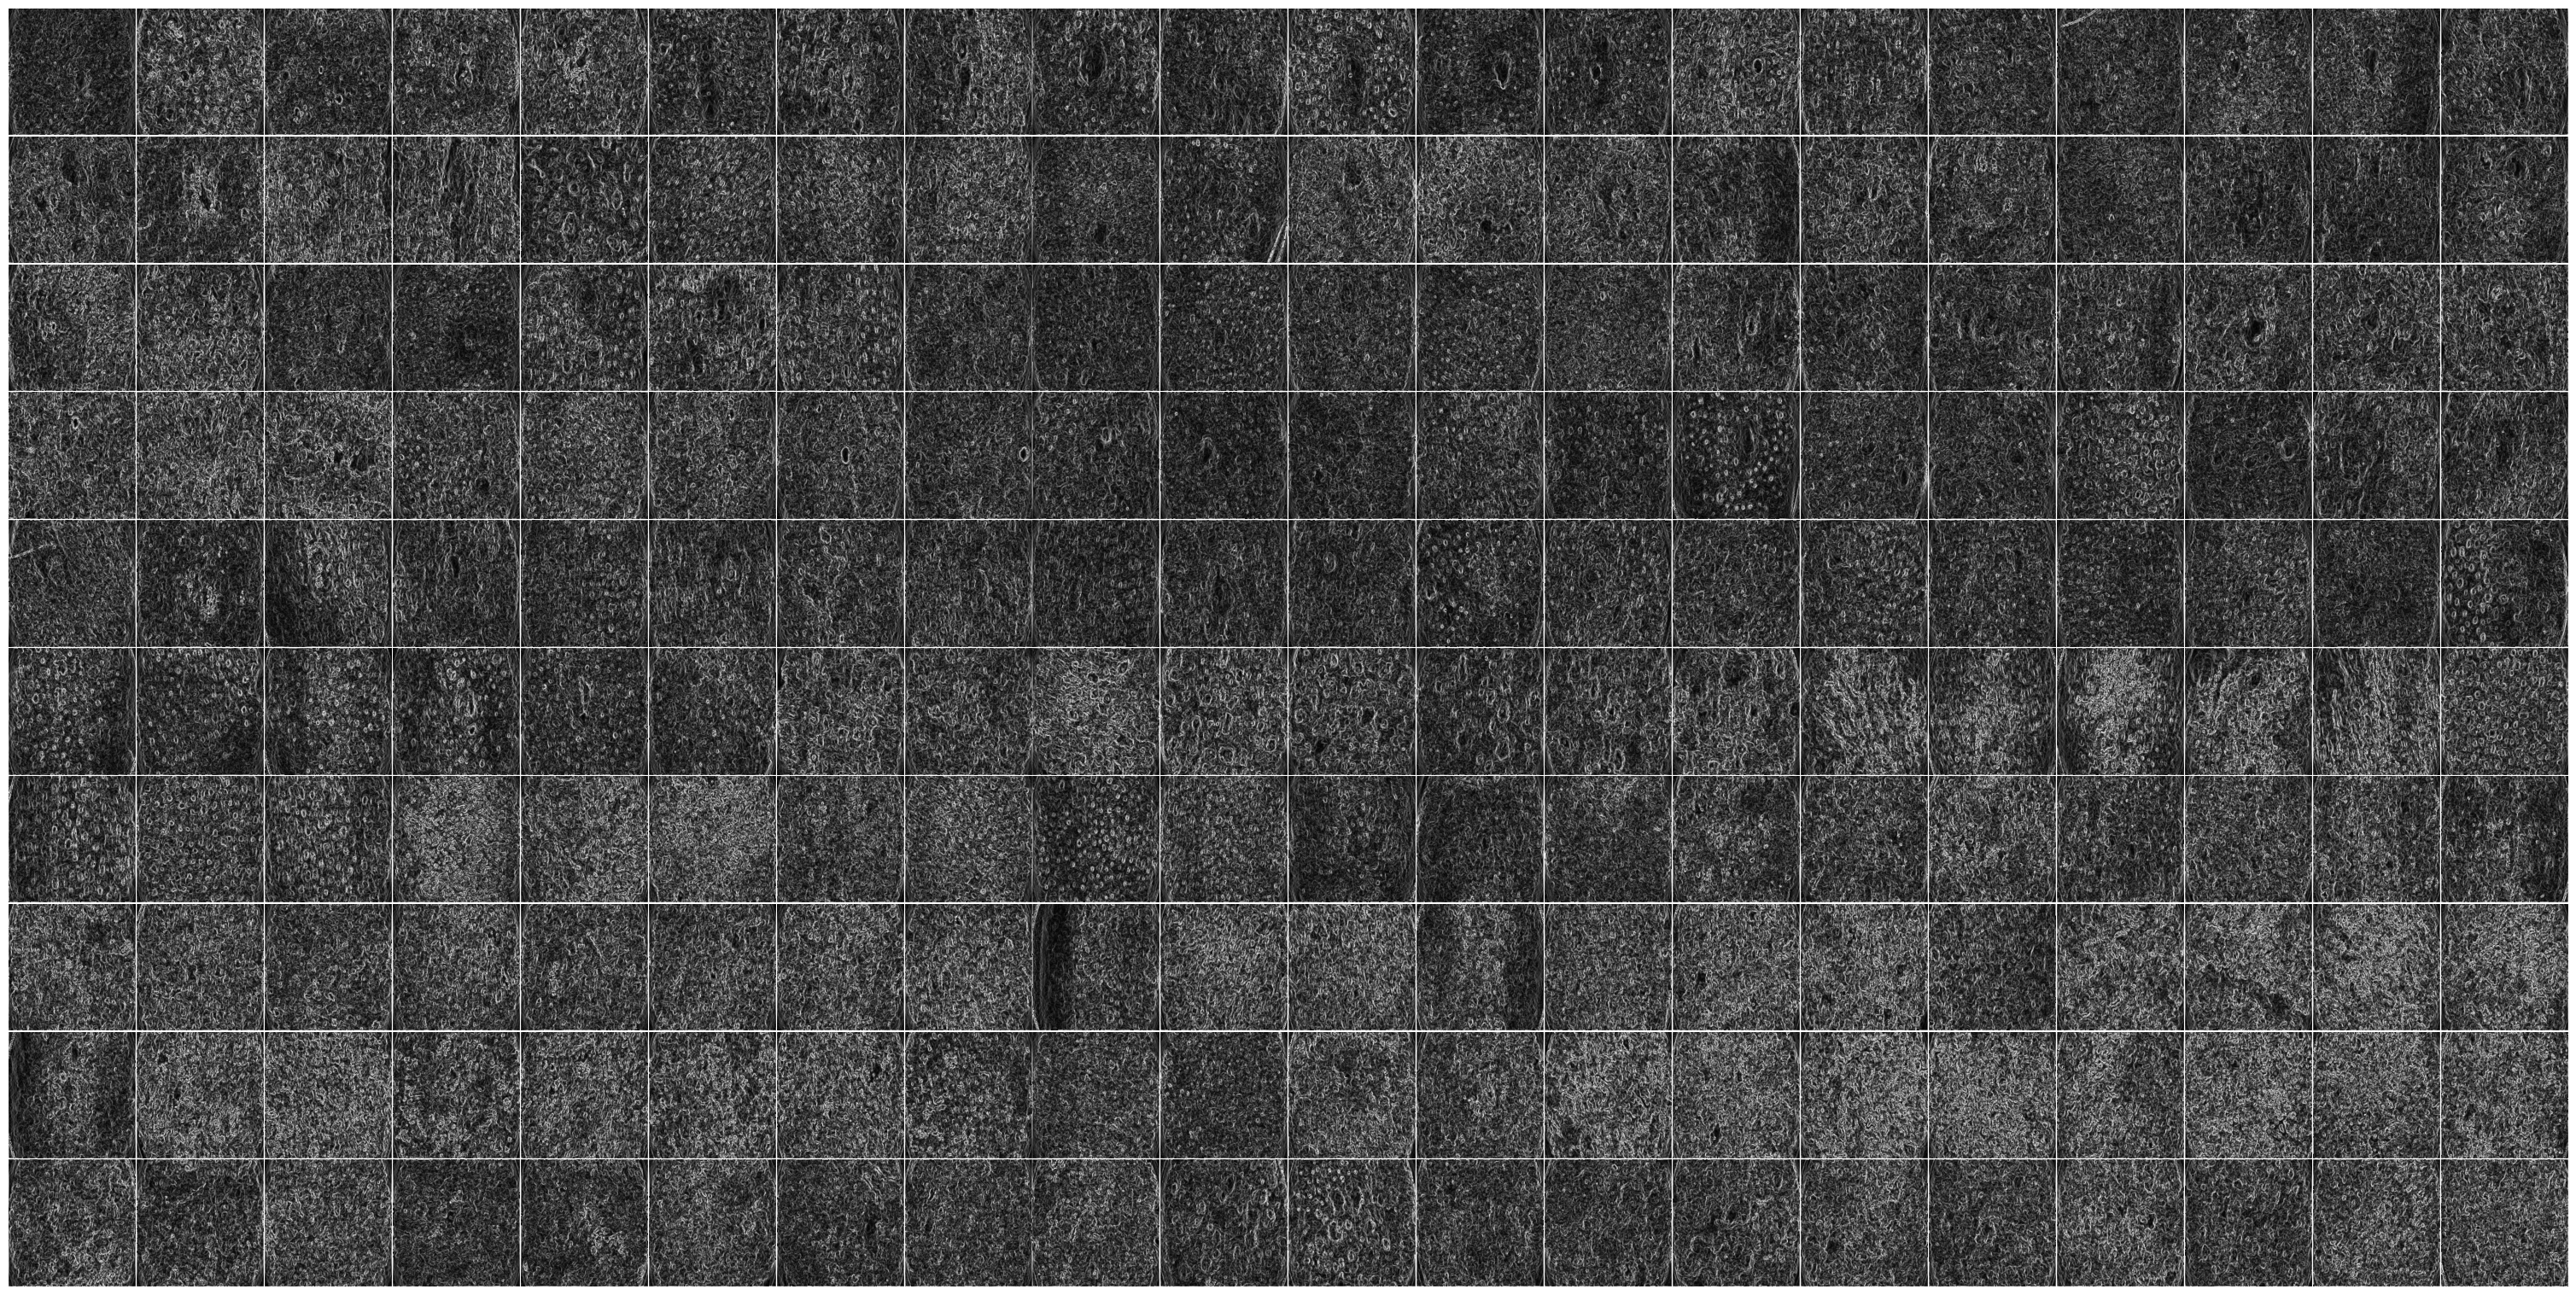

In [387]:
num_images = min(len(images), 200)  

cols = 20  
rows = (num_images // cols) + (1 if num_images % cols else 0)  

fig, axes = plt.subplots(rows, cols, figsize=(30, 15))

for i, ax in enumerate(axes.flat):
    
    if i < num_images:
        img = resize_image(dataPreprocessed[i])  
        ax.imshow(img, cmap='gray')
        ax.axis("off")
    else:
        ax.axis("off")  

plt.tight_layout(pad=0.1)  
plt.show()

<h1>Feature Extraction</h1>

In [388]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [389]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [390]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [391]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [392]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [393]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [394]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [395]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [396]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [397]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [398]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    homogenity0.append(H0)
    H45 = homogenity(Derajat45[i])
    homogenity45.append(H45)
    H90 = homogenity(Derajat90[i])
    homogenity90.append(H90)
    H135 = homogenity(Derajat135[i])
    homogenity135.append(H135)

In [399]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [400]:
for i in range(len(images)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [401]:
for i in range(len(images)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [402]:
for i in range(len(images)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [403]:
for i in range(len(images)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [404]:
for i in range(len(images)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [405]:
print("Jumlah Labels:", len(path))
print("Jumlah Filename:", len(filenames))
print("Jumlah Kontras0:", len(Kontras0), len(Kontras45), len(Kontras90), len(Kontras135))
print("Jumlah Homogeneity0:", len(homogenity0), len(homogenity45), len(homogenity90), len(homogenity135))
print("Jumlah Dissimilarity0:", len(dissimilarity0), len(dissimilarity45), len(dissimilarity90), len(dissimilarity135))
print("Jumlah Entropy0:", len(entropy0), len(entropy45), len(entropy90), len(entropy135))
print("Jumlah ASM0:", len(ASM0), len(ASM45), len(ASM90), len(ASM135))
print("Jumlah Energy0:", len(energy0), len(energy45), len(energy90), len(energy135))
print("Jumlah Correlation0:", len(correlation0), len(correlation45), len(correlation90), len(correlation135))

Jumlah Labels: 200
Jumlah Filename: 200
Jumlah Kontras0: 200 200 200 200
Jumlah Homogeneity0: 200 200 200 200
Jumlah Dissimilarity0: 200 200 200 200
Jumlah Entropy0: 200 200 200 200
Jumlah ASM0: 200 200 200 200
Jumlah Energy0: 200 200 200 200
Jumlah Correlation0: 200 200 200 200


In [406]:
print(df.describe())  # Lihat ringkasan statistik fitur

         Contrast0   Contrast45   Contrast90  Contrast135  Homogeneity0  \
count   200.000000   200.000000   200.000000   200.000000    200.000000   
mean   1622.473703  1997.470552  1009.015098  2020.790142      0.044617   
std     582.953936   648.324304   399.071709   667.374963      0.006955   
min     760.372901  1020.708005   479.515916  1027.185483      0.029770   
25%    1181.907234  1490.724406   714.199387  1518.964667      0.040057   
50%    1488.811229  1871.918954   893.699150  1870.541876      0.044454   
75%    1895.214124  2369.030304  1119.619370  2313.630419      0.049837   
max    3470.656909  3897.689273  2436.354059  4119.705298      0.062024   

       Homogeneity45  Homogeneity90  Homogeneity135  Dissimilarity0  \
count     200.000000     200.000000      200.000000      200.000000   
mean        0.037708       0.057074        0.037515       28.429024   
std         0.005768       0.008662        0.005767        5.070475   
min         0.025223       0.037736     

<h1>CSV</h1>

In [407]:
dataTable = {'Filename': filenames, 'Label': path,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

Filename          Label    Contrast0   Contrast45   Contrast90  \
0    101_5.jpg  Acne Vulgaris   809.753830  1144.785421   572.744991   
1    102_2.jpg  Acne Vulgaris  1839.423070  2156.211857  1438.614859   
2    103_2.jpg  Acne Vulgaris  1159.838848  1524.169150   796.726180   
3    106_1.jpg  Acne Vulgaris  1619.407276  2020.610258  1024.113143   
4    106_7.jpg  Acne Vulgaris  2010.762301  2468.802768  1154.659069   
..         ...            ...          ...          ...          ...   
195  118_2.jpg        Rosacea  1359.558058  1722.624129   867.905530   
196  118_3.jpg        Rosacea  2239.533747  2655.984160  1301.815564   
197  118_4.jpg        Rosacea  1452.070941  1893.455963   887.155637   
198  119_1.jpg        Rosacea  2149.642923  2834.302253  1482.947794   
199  119_2.jpg        Rosacea  2083.995129  2643.606936  1321.187010   

     Contrast135  Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  \
0    1031.858470      0.056280       0.047242       0.069566        0.049445   
1    2569.233849      0.040665       0.034794       0.048403        0.032458   
2    1541.493641      0.051220       0.040405       0.060322        0.040576   
3    1959.777439      0.041539       0.036246       0.053540        0.036060   
4    2275.961507      0.039828       0.033466       0.055298        0.034914   
..           ...           ...            ...            ...             ...   
195  1829.668758      0.043570       0.036624       0.056827        0.036510   
196  2746.289689      0.036377       0.030708       0.048339        0.030097   
197  1781.023283      0.043199       0.036962       0.054894        0.037147   
198  2519.979546      0.036140       0.029543       0.043131        0.031720   
199  2599.926105      0.036208       0.029631       0.044031        0.029560   

     ...     ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0    ...  0.000194  0.000158  0.013080  0.012376  0.013927   0.012557   
1    ...  0.000088  0.000069  0.008897  0.008535  0.009396   0.008322   
2    ...  0.000142  0.000113  0.011268  0.010623  0.011898   0.010624   
3    ...  0.000113  0.000088  0.009730  0.009337  0.010608   0.009379   
4    ...  0.000101  0.000075  0.008971  0.008561  0.010045   0.008688   
..   ...       ...       ...       ...       ...       ...        ...   
195  ...  0.000114  0.000088  0.009928  0.009462  0.010697   0.009377   
196  ...  0.000080  0.000060  0.008136  0.007808  0.008942   0.007764   
197  ...  0.000115  0.000090  0.009925  0.009422  0.010729   0.009482   
198  ...  0.000079  0.000064  0.008304  0.007841  0.008876   0.007982   
199  ...  0.000079  0.000062  0.008236  0.007841  0.008875   0.007855   

     Correlation0  Correlation45  Correlation90  Correlation135  
0        0.551802       0.336528       0.683387        0.401998  
1        0.579610       0.501380       0.670132        0.405881  
2        0.570359       0.420058       0.706342        0.413551  
3        0.546177       0.422529       0.710377        0.439899  
4        0.524257       0.407911       0.726700        0.454136  
..            ...            ...            ...             ...  
195      0.570516       0.444722       0.727284        0.410177  
196      0.513837       0.418077       0.718118        0.398317  
197      0.558619       0.413514       0.731892        0.448411  
198      0.530672       0.375216       0.675919        0.444471  
199      0.511881       0.373717       0.690807        0.384136  

[200 rows x 30 columns]

<Axes: >

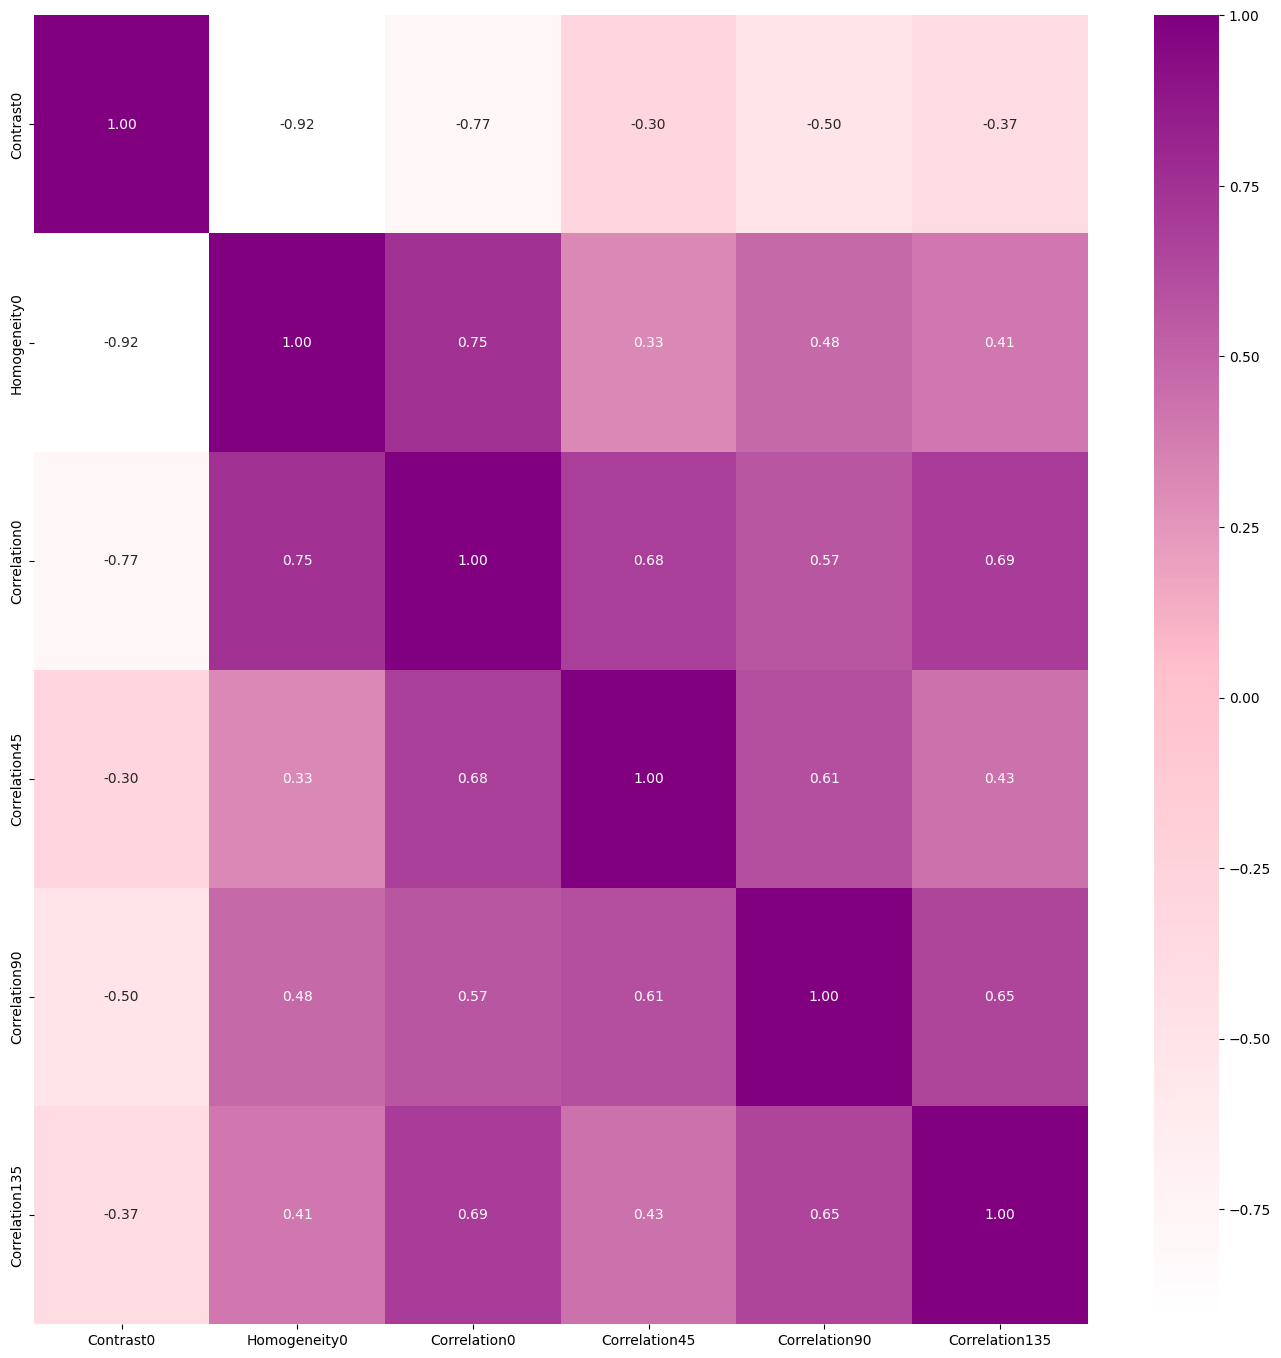

In [408]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))

pink_cmap = LinearSegmentedColormap.from_list("pink_shade", ["white", "pink", "purple"], N=256)
sns.heatmap(x_new.corr(), annot=True, cmap=pink_cmap, fmt=".2f")

In [409]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(140, 6)
(60, 6)


In [410]:

# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [411]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

In [412]:
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------RANDOM FOREST------")
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------RANDOM FOREST------
------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.97      0.94      0.96        69
      Rosacea       0.95      0.97      0.96        71

     accuracy                           0.96       140
    macro avg       0.96      0.96      0.96       140
 weighted avg       0.96      0.96      0.96       140

[[65  4]
 [ 2 69]]
Accuracy: 0.9571428571428572

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.76      0.71      0.73        31
      Rosacea       0.71      0.76      0.73        29

     accuracy                           0.73        60
    macro avg       0.73      0.73      0.73        60
 weighted avg       0.73      0.73      0.73        60

[[22  9]
 [ 7 22]]
Accuracy: 0.7333333333333333


In [413]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------SVM------")
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)

------SVM------

------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.82      0.74      0.78        69
      Rosacea       0.77      0.85      0.81        71

     accuracy                           0.79       140
    macro avg       0.80      0.79      0.79       140
 weighted avg       0.80      0.79      0.79       140

[[51 18]
 [11 60]]
Accuracy: 0.7928571428571428

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.80      0.77      0.79        31
      Rosacea       0.77      0.79      0.78        29

     accuracy                           0.78        60
    macro avg       0.78      0.78      0.78        60
 weighted avg       0.78      0.78      0.78        60

[[24  7]
 [ 6 23]]
Accuracy: 0.7833333333333333


In [414]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------KNN------")
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)

------KNN------

------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.84      0.81      0.82        69
      Rosacea       0.82      0.85      0.83        71

     accuracy                           0.83       140
    macro avg       0.83      0.83      0.83       140
 weighted avg       0.83      0.83      0.83       140

[[56 13]
 [11 60]]
Accuracy: 0.8285714285714286

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.72      0.74      0.73        31
      Rosacea       0.71      0.69      0.70        29

     accuracy                           0.72        60
    macro avg       0.72      0.72      0.72        60
 weighted avg       0.72      0.72      0.72        60

[[23  8]
 [ 9 20]]
Accuracy: 0.7166666666666667


In [415]:
print("\n------Testing Set RF------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

print("\n------Testing Set SVM------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)

print("\n------Testing Set KNN------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Testing Set RF------
               precision    recall  f1-score   support

Acne Vulgaris       0.76      0.71      0.73        31
      Rosacea       0.71      0.76      0.73        29

     accuracy                           0.73        60
    macro avg       0.73      0.73      0.73        60
 weighted avg       0.73      0.73      0.73        60

[[22  9]
 [ 7 22]]
Accuracy: 0.7333333333333333

------Testing Set SVM------
               precision    recall  f1-score   support

Acne Vulgaris       0.80      0.77      0.79        31
      Rosacea       0.77      0.79      0.78        29

     accuracy                           0.78        60
    macro avg       0.78      0.78      0.78        60
 weighted avg       0.78      0.78      0.78        60

[[24  7]
 [ 6 23]]
Accuracy: 0.7833333333333333

------Testing Set KNN------
               precision    recall  f1-score   support

Acne Vulgaris       0.72      0.74      0.73        31
      Rosacea       0.71      0.69      0

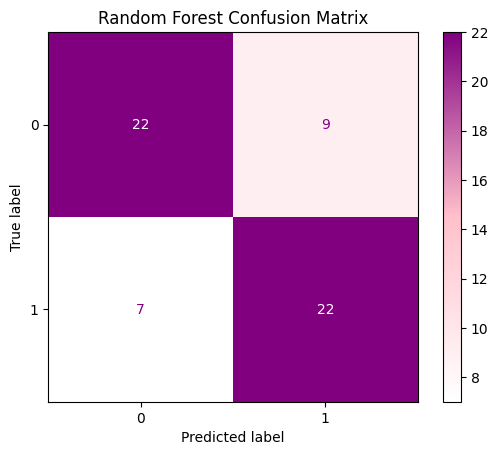

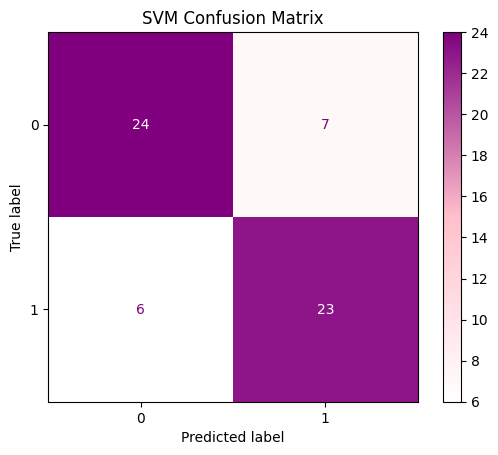

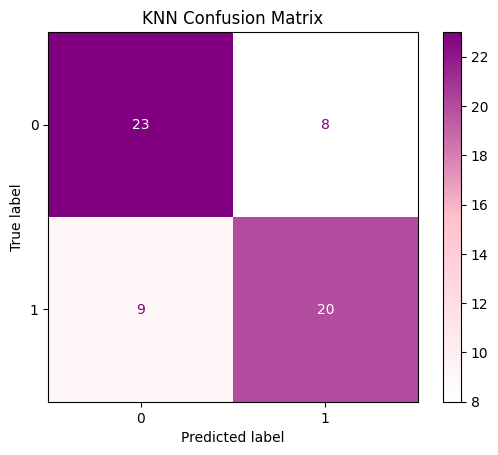

In [416]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=pink_cmap)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")